### ASTR 3300/5300-003: Astrostatistics
***N. Pol***
___

# Homework 3
### Due: Friday, Feb 14th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

In [11]:
import numdifftools as nd
H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
sigma_laplace = np.linalg.inv(H)**0.5

NameError: name 'f_lnlaplace' is not defined

### Solution

In [10]:
import numpy as np

file_path = 'hw_data/hw3_data_1.npy'

data = np.load(file_path, allow_pickle=True)

measurements = data[:, 0]
uncertainties = data[:, 1]

weights = 1 / (uncertainties**2)
weighted_mean = np.sum(weights * measurements) / np.sum(weights)
standard_error = np.sqrt(1 / np.sum(weights))

print(f"\nWeighted Mean: {weighted_mean:.6f}")
print(f"Standard Error: {standard_error:.6f}")



Weighted Mean: 3.917992
Standard Error: 0.094811


In [18]:
from scipy.optimize import minimize

def ln_likelihood(mu, x, sigma):
    return np.sum((x - mu)**2/ (2 * sigma**2) + np.log(2 * np.pi * sigma**2) / 2)

mean = np.mean(measurements)

result = minimize(ln_likelihood, mean, args=(measurements, uncertainties), method='Nelder-Mead')
best_fit_mean = result.x[0]
print(f"Best-fit mean from likelihood maximization: {best_fit_mean:.4f}")

Best-fit mean from likelihood maximization: 3.9180


In [13]:
def ln_likelihood(mu):
    return 0.5 * np.sum((measurements - mu)**2 / uncertainties**2 + np.log(2 * np.pi * uncertainties**2))

weights = 1 / uncertainties**2
best_fit_mean = np.sum(weights * measurements) / np.sum(weights)

H = nd.Hessian(ln_likelihood)([best_fit_mean])
fisher_uncertainty = np.sqrt(1/H[0][0])

print(f"Best-fit mean: {best_fit_mean:.6f}")
print(f"Fisher uncertainty: {fisher_uncertainty:.6f}")


Best-fit mean: 3.917992
Fisher uncertainty: 0.094811


In [20]:
def bootstrap(data, n_bootstrap=1000):
    n_samples = len(data)
    bootstrap_means = np.zeros(n_bootstrap)

    for i in range(n_bootstrap):
        indices = np.random.randint(0, n_samples, size=n_samples)
        boot_measure = data[indices, 0]
        boot_uncertainties = data[indices, 1]
        weights = 1/ boot_uncertainties**2
        bootstrap_means[i] = np.sum(weights * boot_measure) / np.sum(weights)

    return bootstrap_means

bootstrap_results = bootstrap(data, n_bootstrap=1000)
bootstrap_mean = np.mean(bootstrap_results)
bootstrap_std = np.std(bootstrap_results)

print(f"Bootstrap mean: {bootstrap_mean:.4f}")
print(f"Boostrap uncertaintyL {bootstrap_std: .4f}")

Bootstrap mean: 3.9186
Boostrap uncertaintyL  0.0907


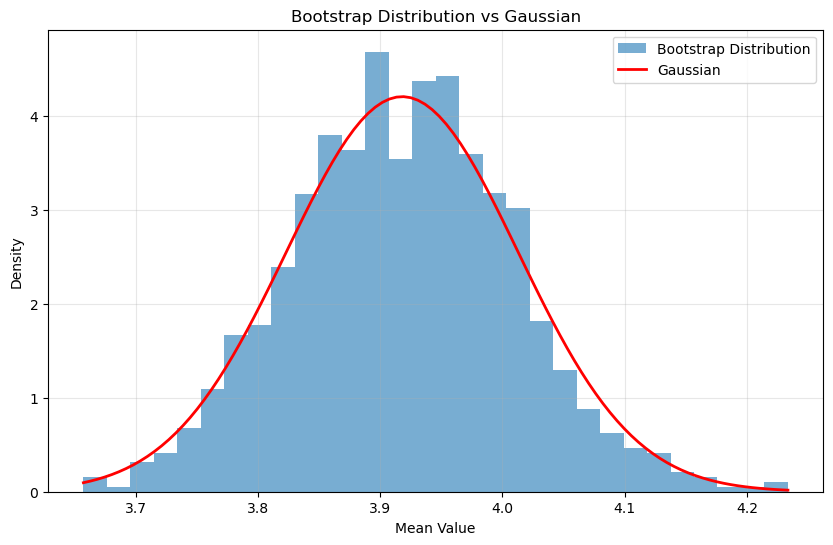

Analytical Mean: 3.917992
Bootstrap Mean: 3.918622
Analytical Std: 0.094811
Bootstrap Std: 0.090689
These value are very similiar. Though not exactly matching


In [25]:
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.figure(figsize=(10, 6))

plt.hist(bootstrap_results, bins=30, density=True, alpha=0.6, label='Bootstrap Distribution')

x = np.linspace(min(bootstrap_results), max(bootstrap_results), 100)

plt.plot(x, norm.pdf(x, weighted_mean, standard_error), 
         'r-', lw=2, label='Gaussian')

plt.xlabel('Mean Value')
plt.ylabel('Density')
plt.title('Bootstrap Distribution vs Gaussian')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Analytical Mean: {weighted_mean:.6f}")
print(f"Bootstrap Mean: {np.mean(bootstrap_results):.6f}")
print(f"Analytical Std: {standard_error:.6f}")
print(f"Bootstrap Std: {np.std(bootstrap_results):.6f}")
print("These value are very similiar. Though not exactly matching")

In [26]:
import numpy as np
from scipy.optimize import minimize

def ln_likelihood_laplace(params, x, sigma):
    mu, delta = params
    return np.sum(np.log(1/(2*delta)) - np.abs(x - mu)/delta)

initial_params = [np.median(measurements), np.std(measurements)]
result_laplace = minimize(lambda p, x, s: -ln_likelihood_laplace(p, x, s),
                         initial_params,
                         args=(measurements, uncertainties),
                         method='Nelder-Mead')
best_mu, best_delta = result_laplace.x

print(f"Best-fit Laplace parameters:")
print(f"Location (mu): {best_mu:.6f}")
print(f"Scale (delta): {best_delta:.6f}")


Best-fit Laplace parameters:
Location (mu): 4.085430
Scale (delta): 0.882269


In [27]:
k_gaussian = 1
gaussian_aic = 2*k_gaussian - 2*(-ln_likelihood(best_fit_mean, measurements, uncertainties))

k_laplace = 2
laplace_aic = 2*k_laplace - 2*(-ln_likelihood_laplace([best_mu, best_delta], measurements, uncertainties))

print(f"Gaussian AIC: {gaussian_aic:.3f}")
print(f"Laplace AIC: {laplace_aic:.3f}")
print(f"\nThe {('Gaussian' if gaussian_aic < laplace_aic else 'Laplace')} model is favored by the data")


Gaussian AIC: 296.516
Laplace AIC: -309.578

The Laplace model is favored by the data


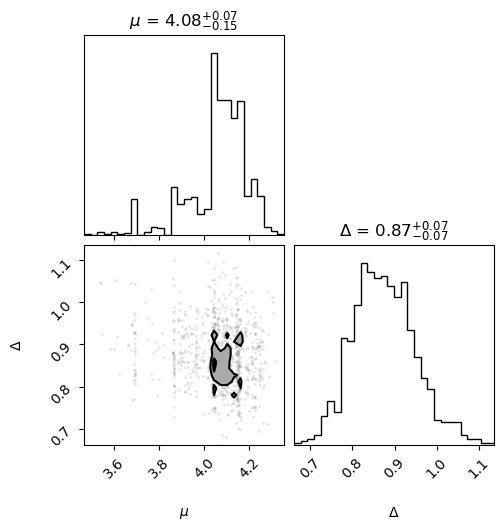

In [28]:
import corner

laplace_params = np.zeros((1000, 2))

for i in range(1000):
    indices = np.random.randint(0, len(measurements), size=len(measurements))
    boot_data = data[indices]
    
    result = minimize(lambda p, x, s: -ln_likelihood_laplace(p, x, s),
                     [np.median(boot_data[:,0]), np.std(boot_data[:,0])],
                     args=(boot_data[:,0], boot_data[:,1]),
                     method='Nelder-Mead')
    
    laplace_params[i] = result.x

fig = corner.corner(laplace_params, 
                   labels=[r"$\mu$", r"$\Delta$"],
                   levels=(0.32, 0.05),
                   show_titles=True,
                   title_kwargs={"fontsize": 12},
                   plot_datapoints=True,
                   fill_contours=True,
                   bins=30)

plt.show()


In [29]:
def laplace_for_hessian(params):
    return -ln_likelihood_laplace(params, measurements, uncertainties)

H = nd.Hessian(laplace_for_hessian)([best_mu, best_delta])
fisher_uncertainties = np.sqrt(np.diag(np.linalg.inv(H)))
bootstrap_uncertainties = np.std(laplace_params, axis=0)

print("Fisher uncertainties:")
print(f"mu: {fisher_uncertainties[0]:.6f}")
print(f"delta: {fisher_uncertainties[1]:.6f}")

print("\nBootstrap uncertainties:")
print(f"mu: {bootstrap_uncertainties[0]:.6f}")
print(f"delta: {bootstrap_uncertainties[1]:.6f}")
print("The delta Fisher and Bootstrap deltas is very similiar to the the delta that was produced")
print("previous problem. The difference in the deltas suggest non-Gaussian behavior.")

Fisher uncertainties:
mu: 0.109225
delta: 0.088227

Bootstrap uncertainties:
mu: 0.132419
delta: 0.073826


In [ ]:
#For problem 6 and 8, I used AI to help with some errors that were being thrown
#up. Specifically the 'Nelder-Mead' method was suggested. Which looking into the method
#a bit  more, (if I understand correctly) it is used to find the minimum of a function by 
#manipulating geometric shapes that cuts out the need for derivatives. It is typically
#used for 2-D problems (like this one!) and apparently it is the default choice for 
#scipy.optimize.minimize. 